# Python Libs

In [72]:
import gluoncv as gcv
import mxnet as mx
# mxnet NDarray 
from mxnet import nd

# MXNet Gluon Neural network layers.
from mxnet.gluon import nn

# optional for displaying the image
import matplotlib.pyplot as plt
#import numpy as np
import os
import math

# Rotate Matrix

In [73]:
def build_rot_matrix(angle):
    
    # calculate terms
    a = math.cos(x)
    b = -math.sin(x)
    c = math.sin(x)
    d = math.cos(x)

    # build nd array
    nd_array = nd.array([
        [a,b],
        [c,d]
    ])
    
    return nd_array

#### rotate 0 matrix

In [74]:
x=0

rotate_0 = build_rot_matrix(x)
print('rotate by 0 nd array is ', rotate_0)

rotate by 0 nd array is  
[[ 1. -0.]
 [ 0.  1.]]
<NDArray 2x2 @cpu(0)>


#### rotate 45 matrix

In [75]:
x=0.25*math.pi

rotate_45 = build_rot_matrix(x)
print('rotate by 45 nd array is ', rotate_45)

rotate by 45 nd array is  
[[ 0.70710677 -0.70710677]
 [ 0.70710677  0.70710677]]
<NDArray 2x2 @cpu(0)>


#### rotate 90 matrix

In [76]:
x=0.5*math.pi

rotate_90 = build_rot_matrix(x)
print('rotate by 90 nd array is ', rotate_90)

rotate by 90 nd array is  
[[ 6.123234e-17 -1.000000e+00]
 [ 1.000000e+00  6.123234e-17]]
<NDArray 2x2 @cpu(0)>


#### rotate 180 matrix

In [77]:
x=math.pi

rotate_180 = build_rot_matrix(x)
print('rotate by 180 nd array is ', rotate_180)

rotate by 180 nd array is  
[[-1.0000000e+00 -1.2246469e-16]
 [ 1.2246469e-16 -1.0000000e+00]]
<NDArray 2x2 @cpu(0)>


# Generic Rotate Routine

In [78]:
def my_print(verbose=False, *args):
    if (verbose):
        print(args)

In [79]:
def my_rotate(input_image_batch, rotate_matrix, verbose=False):
    # NDArrayIter(data, label=None, batch_size=1, shuffle=False, 
    #            last_batch_handle='pad', data_name='data', 
    #            label_name='softmax_label')
    #
    # Ignore the label parameter.
    dataiter = mx.io.NDArrayIter(input_image_batch, batch_size=1, shuffle=False, last_batch_handle='discard')
    for batch in dataiter:

        my_print(verbose, 'loop entry - a single batch - a single image in batch.data[0] from what is in in_data')
        
        
        # Does this copy or get an alias to the input image?
        a_img_batch = batch.data[0]
        my_print(verbose, 'a_img_batch = ', a_img_batch)
        my_print(verbose, 'a_img_batch.shape = ', a_img_batch.shape)

        #
        # Remember the dims so we can reshare the flattened array back to rectangular
        orig_dims = a_img_batch[0].shape
        
        
        a_img_indexes = mx.nd.contrib.index_array(a_img_batch, axes=(1, 2))
        my_print(verbose, 'a_img_indexes  ', a_img_indexes)
        my_print(verbose, 'a_img_indexes.shape ', a_img_indexes.shape)



        # Try to assign input data to output data based upon indicies
        #
        # Need to reshape so that rows=size of image sans batch
        # 2x2-> 4,2
        # 3x3-> 9,2
        #
        num_rows = a_img_batch[0].size
        my_print(verbose,'num_rows = ', num_rows)
        orig_indexes = mx.nd.reshape(a_img_indexes, shape=(num_rows,2))
        my_print(verbose, 'orig_indexes ', orig_indexes)
        orig_indexes = orig_indexes.astype("float32")

        # do the rotate
        new_indexes = nd.dot(orig_indexes, rotate_matrix) 
        my_print(verbose, 'new_indexes = ', new_indexes)
        new_indexes = new_indexes.astype('int64')
        my_print(verbose, 'new_indexes = ', new_indexes)
        #
        # shift to lower right quadrant. shift so that index axes is 0,0 in top left
        #
        # find the min row value
        min_row = new_indexes.min(axis=0)[0]
        my_print(verbose, 'min_row = ', min_row)
        adj_row = nd.abs(min_row).asscalar()
        my_print(verbose, 'adj_row = ', adj_row)
        
        # find the min col value
        min_col = new_indexes.min(axis=0)[1]
        my_print(verbose, 'min_col = ', min_col)
        adj_col = nd.abs(min_col).asscalar()
        my_print(verbose, 'adj_col = ', adj_col)
        
        #
        # Gordian knot fix for rectangular images.  Pad (or crop) the image to make
        # it square.  I'll choose to pad.  See make rectangular routine
        #
        
        
        
 
        # adjust based upon min row/col
        # with rotate 90 for 3x3 its [0,2]
        new_indexes = new_indexes + nd.array(nd.array([adj_row, adj_col])).astype('int64')
        my_print(verbose, 'new_indexes after shift to positive', new_indexes)

        #
        # The output image needs to be resized to match new dimensions.
        #
        
        #
        # Determine the max dim in array
        # 
        # find the min row value
        max_row = new_indexes.max(axis=0)[0].asscalar() + 1
        my_print(verbose, 'max_row = ', max_row)
        
        # find the min col value
        max_col = new_indexes.max(axis=0)[1].asscalar() + 1
        my_print(verbose, 'max_col = ', max_col)

        # This only works for square images rotated in 90 degree increments
        #output_image_batch = nd.zeros(input_image_batch.size).reshape(input_image_batch.shape)
        # Use new max col and max row
        output_image_batch = nd.zeros(input_image_batch.size).reshape([1, max_row, max_col])

        
        output_image = output_image_batch[0]
        
             
    
        output_image = a_img_batch[0][new_indexes[:,0],new_indexes[:,1]]
        my_print(verbose, 'output_image ', output_image)
                
        output_image = output_image.reshape( max_row, max_col)    
        
        my_print(verbose, 'output_image ', output_image)
        output_image_batch = nd.expand_dims(output_image, axis=0)
        my_print(verbose, 'output_image_batch ', output_image_batch)
        
        return output_image_batch


# Why make rectangular?

When the image is non square, pixel indices will reference non addressable pixels.  Perhaps that is a way to say it.  Its easier to explain with a picture.  TLDR the rotated and adjusted indices in the 0,0 top left coordinate system refer to indices not in the original image.  The process for fixing the problem is discussed in the hand written notes.


![img](imgs/ImageRotate-23.jpg)


In [80]:
def make_square(input_image_batch, verbose=False):
    # NDArrayIter(data, label=None, batch_size=1, shuffle=False, 
    #            last_batch_handle='pad', data_name='data', 
    #            label_name='softmax_label')
    #
    # Ignore the label parameter.
    dataiter = mx.io.NDArrayIter(input_image_batch, batch_size=1, shuffle=False, last_batch_handle='discard')
    for batch in dataiter:

        my_print(verbose, 'loop entry - a single batch - a single image in batch.data[0] from what is in in_data')
        
        
        # Does this copy or get an alias to the input image?
        a_img_batch = batch.data[0]
        my_print(verbose, 'a_img_batch = ', a_img_batch)
        my_print(verbose, 'a_img_batch.shape = ', a_img_batch.shape)

        (num_rows, num_cols) = in_img_batch[0].shape
        
        rect_dim = max(num_rows,num_cols)

        # I need a 0 when its 2x3
        # I need a 1 when its 3x2
        #
        # By extensions, I need a 1 when num_rows > num_cols
        #
        # I don't know any other way to do this.
        if num_rows > num_cols:
            mod_axis = 1
        else:
            mod_axis = 0


        #
        # pad only works with 4-d and 5d?
        #
        # nd.pad(in_img, mode='constant', constant_value=0,pad_width=(rect_dim,rect_dim))
        #

        new_vals = nd.zeros(rect_dim)

        #new_vals2 = nd.expand_dims(new_vals,axis=1) # 3x2 works
        #new_vals2 = nd.expand_dims(new_vals,axis=0) # 2x3 works
        new_vals2 = nd.expand_dims(new_vals,axis=mod_axis) 

        #nd.concat(in_img, new_vals2, dim=1) # 3x2 works
        #nd.concat(in_img, new_vals2, dim=0) # 2x3 works

        
        #
        # Don't know how to do this without a loop either
        #
        # There is a contrib api called nd.contrib.while_loop()
        #

        out_img = in_img_batch[0]
        
        the_diff = abs(num_rows - num_cols)
        print("the_diff = ", the_diff)
        while (the_diff > 0):
            out_img = nd.concat(out_img, new_vals2, dim=mod_axis) 
            the_diff = the_diff - 1
        
        
        out_img_batch = out_img.expand_dims(axis=0)
        return out_img_batch


# Test make_square with 3x2

In [81]:
# Input Image 
in_img_batch = nd.arange(6).reshape((1,3,2))
print('in_img_batch is ', in_img_batch)
in_img = in_img_batch[0]
print('in_img ', in_img)
print('in_img.shape ', in_img.shape)

in_img_batch is  
[[[0. 1.]
  [2. 3.]
  [4. 5.]]]
<NDArray 1x3x2 @cpu(0)>
in_img  
[[0. 1.]
 [2. 3.]
 [4. 5.]]
<NDArray 3x2 @cpu(0)>
in_img.shape  (3, 2)


In [82]:
out_img_batch = make_square(in_img_batch)
out_img_batch

the_diff =  1



[[[0. 1. 0.]
  [2. 3. 0.]
  [4. 5. 0.]]]
<NDArray 1x3x3 @cpu(0)>

# Test make_rectangular with 2x3

In [83]:
# Input Image 
in_img_batch = nd.arange(6).reshape((1,2,3))
print('in_img_batch is ', in_img_batch)
in_img = in_img_batch[0]
print('in_img ', in_img)
print('in_img.shape ', in_img.shape)

in_img_batch is  
[[[0. 1. 2.]
  [3. 4. 5.]]]
<NDArray 1x2x3 @cpu(0)>
in_img  
[[0. 1. 2.]
 [3. 4. 5.]]
<NDArray 2x3 @cpu(0)>
in_img.shape  (2, 3)


In [84]:
out_img_batch = make_square(in_img_batch)
out_img_batch

the_diff =  1



[[[0. 1. 2.]
  [3. 4. 5.]
  [0. 0. 0.]]]
<NDArray 1x3x3 @cpu(0)>

# Test make_rectangular with 2x6

In [85]:
# Input Image 
in_img_batch = nd.arange(12).reshape((1,2,6))
print('in_img_batch is ', in_img_batch)
in_img = in_img_batch[0]
print('in_img ', in_img)
print('in_img.shape ', in_img.shape)

in_img_batch is  
[[[ 0.  1.  2.  3.  4.  5.]
  [ 6.  7.  8.  9. 10. 11.]]]
<NDArray 1x2x6 @cpu(0)>
in_img  
[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]]
<NDArray 2x6 @cpu(0)>
in_img.shape  (2, 6)


In [86]:
out_img_batch = make_square(in_img_batch)
out_img_batch

the_diff =  4



[[[ 0.  1.  2.  3.  4.  5.]
  [ 6.  7.  8.  9. 10. 11.]
  [ 0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.]]]
<NDArray 1x6x6 @cpu(0)>

## Test rotate with 2x3 rotate 90

In [87]:
# Input Image 
in_img_batch = nd.arange(6).reshape((1,3,2))
print('in_img_batch is ', in_img_batch)
in_img = in_img_batch[0]
print('in_img ', in_img)

in_img_batch is  
[[[0. 1.]
  [2. 3.]
  [4. 5.]]]
<NDArray 1x3x2 @cpu(0)>
in_img  
[[0. 1.]
 [2. 3.]
 [4. 5.]]
<NDArray 3x2 @cpu(0)>


In [88]:
in_img_batch = make_square(in_img_batch)
in_img_batch

the_diff =  1



[[[0. 1. 0.]
  [2. 3. 0.]
  [4. 5. 0.]]]
<NDArray 1x3x3 @cpu(0)>

In [89]:
out_img_batch = my_rotate(in_img_batch, rotate_90)
out_img_batch


[[[0. 0. 0.]
  [1. 3. 5.]
  [0. 2. 4.]]]
<NDArray 1x3x3 @cpu(0)>

## Test 90 with 3x3

In [90]:
# Input Image 
in_img_batch = nd.arange(9).reshape((1,3,3))
print('in_img_batch is ', in_img_batch)
in_img = in_img_batch[0]
print('in_img ', in_img)

in_img_batch is  
[[[0. 1. 2.]
  [3. 4. 5.]
  [6. 7. 8.]]]
<NDArray 1x3x3 @cpu(0)>
in_img  
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
<NDArray 3x3 @cpu(0)>


In [91]:
in_img_batch = make_square(in_img_batch)
in_img_batch

the_diff =  0



[[[0. 1. 2.]
  [3. 4. 5.]
  [6. 7. 8.]]]
<NDArray 1x3x3 @cpu(0)>

In [92]:
out_img_batch = my_rotate(in_img_batch, rotate_90)
out_img_batch


[[[2. 5. 8.]
  [1. 4. 7.]
  [0. 3. 6.]]]
<NDArray 1x3x3 @cpu(0)>

# Test with real image of long neck deer

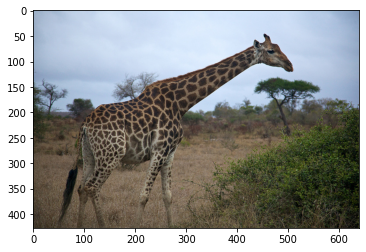

In [93]:
a_file_name = './0.jpg'
nd_array_uint8_HWC3 = mx.image.imread(a_file_name)
nd_array_f32_HWC3 = nd_array_uint8_HWC3.astype("float32")
nd_array_f3201_HWC3 = nd_array_f32_HWC3/255
plt.imshow(nd_array_f3201_HWC3.asnumpy())

# Convert to grayscale

#### Using mxnet

nd_array_f3201_HWC3.shape =  (427, 640, 3)
nd_array_f3201_HWC1.shape =  (427, 640)


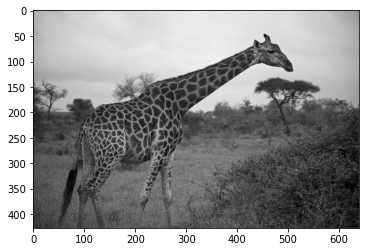

In [94]:
gray_aug = mx.image.RandomGrayAug(p=1)

# Use the RandomGrayAug Image Augment routine to convert to Grayscale
aug = mx.image.RandomGrayAug(p=1)


nd_array_f3201_HWC3 = aug(nd_array_f3201_HWC3)
# This just sets all three channels to same value.
print('nd_array_f3201_HWC3.shape = ', nd_array_f3201_HWC3.shape)

nd_array_f3201_HWC1 = nd_array_f3201_HWC3[:,:,0] # can pick any channel
print('nd_array_f3201_HWC1.shape = ', nd_array_f3201_HWC1.shape)
plt.imshow(nd_array_f3201_HWC1.asnumpy(), cmap='gray')

# Make Batch

In [95]:
in_img_batch = nd_array_f3201_HWC1.expand_dims(axis=0)

# Make Square

In [97]:
in_img_batch = make_square(in_img_batch)
in_img_batch

the_diff =  0



[[[0.66882354 0.6724706  0.6705491  ... 0.5800785  0.5879216  0.584     ]
  [0.66854906 0.6786667  0.67474514 ... 0.5781569  0.5879216  0.584     ]
  [0.67356867 0.6825883  0.6825883  ... 0.58207846 0.584      0.57615685]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
<NDArray 1x640x640 @cpu(0)>

# Rotate by 90

shape of image is now  (640, 640)


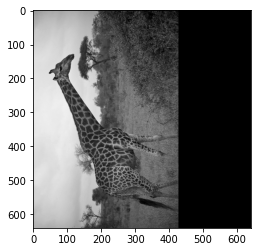

In [98]:
out_img_batch = my_rotate(in_img_batch, rotate_90)
plt.imshow(out_img_batch[0].asnumpy(), cmap='gray')
print("shape of image is now ", out_img_batch[0].shape)

# Rotate by 45

In [99]:
out_img_batch = my_rotate(in_img_batch, rotate_45, True)
plt.imshow(out_img_batch[0].asnumpy(), cmap='gray')

('loop entry - a single batch - a single image in batch.data[0] from what is in in_data',)
('a_img_batch = ', 
[[[0.66882354 0.6724706  0.6705491  ... 0.5800785  0.5879216  0.584     ]
  [0.66854906 0.6786667  0.67474514 ... 0.5781569  0.5879216  0.584     ]
  [0.67356867 0.6825883  0.6825883  ... 0.58207846 0.584      0.57615685]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
<NDArray 1x640x640 @cpu(0)>)
('a_img_batch.shape = ', (1, 640, 640))
('a_img_indexes  ', 
[[[[  0   0]
   [  0   1]
   [  0   2]
   ...
   [  0 637]
   [  0 638]
   [  0 639]]

  [[  1   0]
   [  1   1]
   [  1   2]
   ...
   [  1 637]
   [  1 638]
   [  1 639]]

  [[  2   0]
   [  2   1]
   [  2   2]
   ...
   [  2 637]
   [  2 638]
   [  2 639]]

  ...

  [[637   0]
   [637   1]
   [637   2]
   ...
   [637 637]
   [637 638]
   [637

MXNetError: Traceback (most recent call last):
  File "../src/ndarray/ndarray.cc", line 250
NDArray.Reshape: Check failed: shape_.Size() >= shape.Size() (409600 vs. 816312) : target shape size is larger than the current shape

# Take the input image rotate it, and then remove black

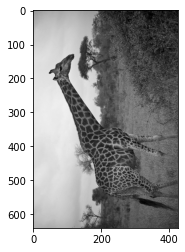

In [100]:
out_img_batch = my_rotate(in_img_batch, rotate_90)
#
# remove any rows with sum to zero
#
out_img = out_img_batch[0]
# I know the rotated image has addtional columns..  
# I also know the image is 640x640
a_cumsum_array = nd.cumsum(out_img, axis=0)[639,:]

# create a sequence array using python.  This could be done once.
Sequence_array = nd.zeros(640)
for i in range(640):
    Sequence_array[i] = i

last_column_of_data = nd.where(a_cumsum_array==0, x=a_cumsum_array, y=Sequence_array).max().astype('int64').asscalar()
last_column_of_data

orig_size_image = out_img_batch[0,:,0:last_column_of_data]
plt.imshow(orig_size_image.asnumpy(), cmap='gray')